# 4. Disordered Systems

A piece of magnetic material exposed to an increasing external field H(t) will magnetize and display an hysteresis loop (see Figure). If one takes the derivative of the loop one observed aeries of sharp jumps, or avalanches (see inset). These avalanches arise as magnetic domain walls in the material are pushed by the external field through a rugged potential energy landscape due to irregularities and impurities in the magnet. The magnetic signal resulting from these random avalanches is called Barkhausen noise .

![image.png](attachment:048ce85f-8845-40b0-9a76-d2d2bfb8fa72.png)

One can model this system with a non-equilibrium lattice model, the random  eld Ising model. The Hamiltonian or energy function for the
model is
$$\mathcal{H} = -\sum_{\langle i,j \rangle}Js_i s_j
-\sum_i(H+h_i)s_i, $$
where the spins $s_i = \pm 1$ lie on a square or cubic lattice with periodic boundary conditions. The coupling and the external field H are as in the traditional Ising model (explored in Section 2). The disorder
in the magnet is incorporated using the random field $h_i$, which is independently chosen at each lattice site from a Gaussian probability distribution of standard deviation $R$:
$$\rho(h)=\exp(-h^2/2R^2)/\sqrt{2\pi}R$$

Here we are not interested in thermal equilibrium, but the opposite ex-
treme: we set the temperature to zero and change the field. We start with all spins pointing down, and adiabatically (infinitely slowly) increase $H(t)$ from $-\infty$
to $\infty$.

The rules for evolving the spin configuration are simple: each spin
ips over when doing so would decrease the energy. This occurs at site i when the local field at that site ($f_i$) changes sign or:
$$s_i =\mbox{sign}(f_i)=\mbox{sign}(J\sum_j s_j  + h_i +H).$$


## The brute force algorithm
On the computer, changing the external  field infinitely slowly is easy. To start a new avalanche (or the first avalanche), one searches for the
unflipped spin that is next to flip, jumps the  field H to just enough to
ip it, and propagates the avalanche, as follows:

(1) Find the triggering spin i for the next avalanche, which is the unflipped site with the largest internal field $f_i$.

(2) Increment the external  field H to minus this internal field, and push the spin onto a first-in first-out queue.
![image.png](attachment:26767022-e746-435d-8654-f09a824686da.png)

(3) Pop the top spin off the queue.

(4) If the spin has not been flipped, flip it and
push all un flipped neighbors with positive local fields onto the queue.

(5) While there are spins on the queue, repeat from step (3).

(6) Repeat from step (1) until all the spins are flipped.


#### Exercise 4.1
- Write a function InitLattice to set up lattices s[m][n] and h[m][n] on the computer. (If you do three dimensions, add an extra index to the arrays.) Fill the former with down-spins (-1) and the latter with random  fields (real numbers chosen from the distribution above).

- Write a function FlipSpin for the lattice, which given i and j flips the spin from s = -1 to s = +1 (complaining if it is already fliipped).

- Write a function NeighborsUp which calculates the number of up-neighbors for the spin (implementing the periodic boundary conditions).

In [1]:
import pylab
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import random
from matplotlib.colors import ListedColormap
%matplotlib inline
from numba import jit

In [2]:
def InitLattice(m,n,R):
    """
    Function to set up a lattice of size nxm and set the spins
    to -1 and chose Gaussian random fields with variance R

    Returns:
    s,h
    """
    s = np.full((m,n),-1)
    h = np.random.normal(0,R,size=(m,n))
    return s,h

In [3]:
s,h = InitLattice(5,5,0.4)

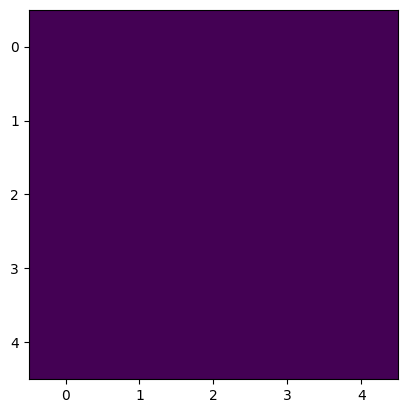

In [4]:
plt.imshow(s)

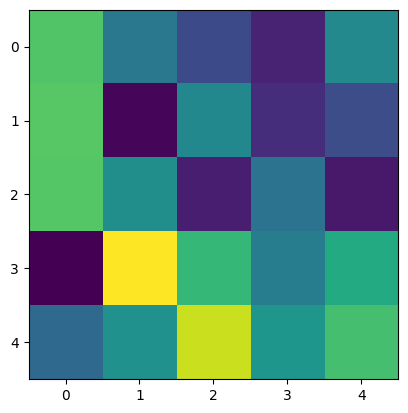

In [5]:
plt.imshow(h)

In [6]:
def FlipSpin(i,j,s):
    """
    Function to flip spin at i,j from the matrix s
    if the spin was not already flipped.

    flag=1 if the spin was unflipped
    flag=0 if the spin was flipped

    Returns: s, flag
    """
    if s[i][j] == -1:
      flag = 1
      s[i][j] = 1
    else:
      flag = 0

    return s,flag

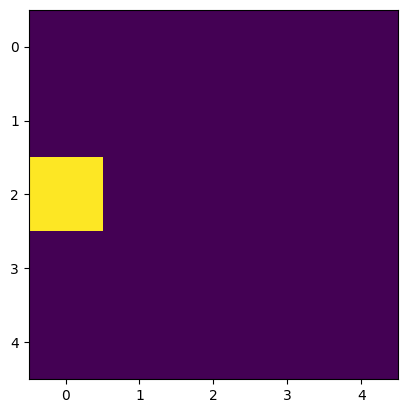

In [7]:
plt.imshow(FlipSpin(2,0,s)[0])

In [8]:
def NeighborsUp(i,j,s):
    """
    Function that counts the numbers of up spins n_up that are neighbors
    of i,j in the matrix s. It implements periodic boundary condition
    along both directions.

    Returns: number of up spins
    """
    y,x = s.shape
    n_up = 0

    up_i = (i - 1) % y
    down_i = (i + 1) % y

    left_j = (j - 1) % x
    right_j = (j + 1) % x

    if s[up_i, j] == 1:
        n_up += 1
    if s[down_i, j] == 1:
        n_up += 1
    if s[i, left_j] == 1:
        n_up += 1
    if s[i, right_j] == 1:
        n_up += 1
    return  n_up

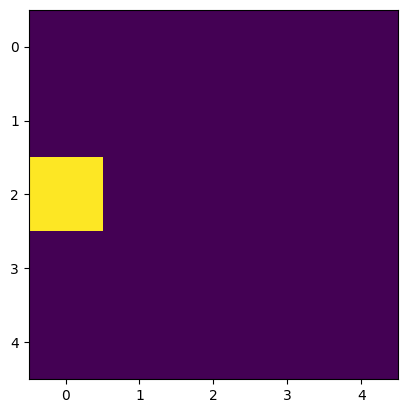

In [9]:
plt.imshow(s)

#### Exercise 4.2
Write a function BruteForceNextAvalanche for step (1), which checks the local  felds of all of the unflipped spins, and returns the location of the next to flip.

In [10]:
@jit
def BruteForceNextAvalanche(s,h,J,H):
    """ function to check the local felds of all of the unflipped spins
    Input: spins s, random fields h, coupling J
    Returns: i,j coordinates of the next spin to flip
    """
    local_field = np.zeros(s.shape)
    i_max = 0
    j_max = 0
    max_field = -np.infty
    for i in range(s.shape[0]):
      for j in range(s.shape[1]):
        if s[i,j] == -1:
          sum_neigh = -4 + 2 * NeighborsUp(i,j,s)
          local_field[i,j] = J * sum_neigh + h[i,j] + H
          if local_field[i,j] > max_field:
            i_max = i
            j_max = j
            max_field = local_field[i,j]

    if max_field != -np.infty:
      return i_max, j_max, max_field
    else:
      print("No -1 spin")

<ipython-input-10-c8fbeeade7d4>:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def BruteForceNextAvalanche(s,h,J,H):


#### Exercise 4.3
Write a function PropagateAvalanche that propagates an avalanche given the triggering spin, steps (3)-(5), coloring the spins that are flipped within
the same avalanche with the same color.

Run a 300x300 system at $R = 1.4$, $0.9$, and $0.7$ and and display the avalanches.

Here is an example of what the a final map of avalanches might look like. It is in B&W, but you should use colors.

![image.png](attachment:0a661bcb-b181-473e-92ed-78856b1185a8.png)



In [11]:
class Queue:

  def __init__(self):
    self.items = []

  def isEmpty(self):
    return self.items == []

  def enqueue(self,item):
    self.items.insert(0,item)

  def dequeue(self):
    return self.items.pop()

In [12]:
@jit
def PropagateAvalanche(s,h,J,H):
    """function that propagates an avalanche given the triggering spin at i,j
    coloring the spins that are flipped """
    q = Queue()
    same_avalance = []
    i, j, fm = BruteForceNextAvalanche(s,h,J,H)
    H_increment = - fm
    H += H_increment
    q.enqueue([i,j])
    same_avalance.append([i,j])
    while q.isEmpty() == False:
      i, j = q.dequeue()
      _, flag = FlipSpin(i,j,s)
      if flag == 1:
        y = s.shape[0]
        x = s.shape[1]
        left_i = (i-1) % x
        right_i = (i+1) % x
        up_j = (j+1) % y
        down_j = (j-1) % y
        neigh = [[left_i,j], [right_i,j], [i,up_j], [i,down_j]]
        for i, j in neigh:
          sum_neigh = -4 + 2 * NeighborsUp(i,j,s)
          local_field = J * sum_neigh+h[i,j] + H
          if local_field > 0 and s[i,j] == -1:
            q.enqueue([i,j])
            same_avalance.append([i,j])
    return same_avalance, H

<ipython-input-12-db6a76a1fd92>:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def PropagateAvalanche(s,h,J,H):


In [14]:
%%time
s,h = InitLattice(300,300,1.4)
all_avalanches = []
H = -1000000000
J = 1
while np.count_nonzero(s == -1)> 0:
  same_avalanche, H = PropagateAvalanche(s,h,J,H)
  all_avalanches.append(same_avalanche)

CPU times: user 19min 28s, sys: 2.52 s, total: 19min 30s
Wall time: 20min 38s


<ipython-input-15-9455c8efa5c2>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Spectral', num_groups)


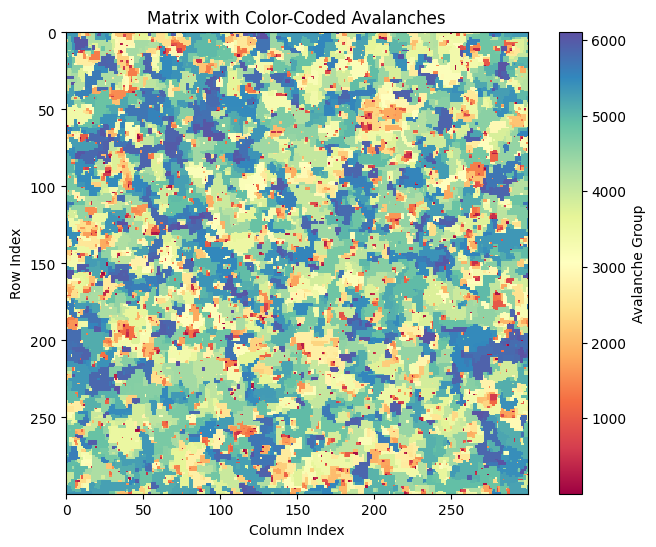

In [15]:
num_groups = len(all_avalanches)
colors = plt.cm.get_cmap('Spectral', num_groups)
color_dict = {i: colors(i)for i in range(num_groups)}

color_matrix = np.zeros_like (s, dtype=float)

for group_idx, avalanche in enumerate(all_avalanches):
  for idx in avalanche:
    i, j = idx
    color_matrix[i, j] = group_idx + 1

plt.figure(figsize=(8, 6))
plt.imshow(color_matrix, cmap=ListedColormap(list(color_dict.values())), interpolation='nearest')
plt.colorbar(label='Avalanche Group')
plt.title('Matrix with Color-Coded Avalanches')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

In [16]:
s,h = InitLattice(300,300,0.9)
avalanches = []
H = -1000000000
J = 1
while np.count_nonzero(s == -1) > 0:
  same_avalanche, H = PropagateAvalanche(s,h,J,H)
  avalanches.append(same_avalanche)

<ipython-input-17-d4dd17902617>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Spectral', num_groups)


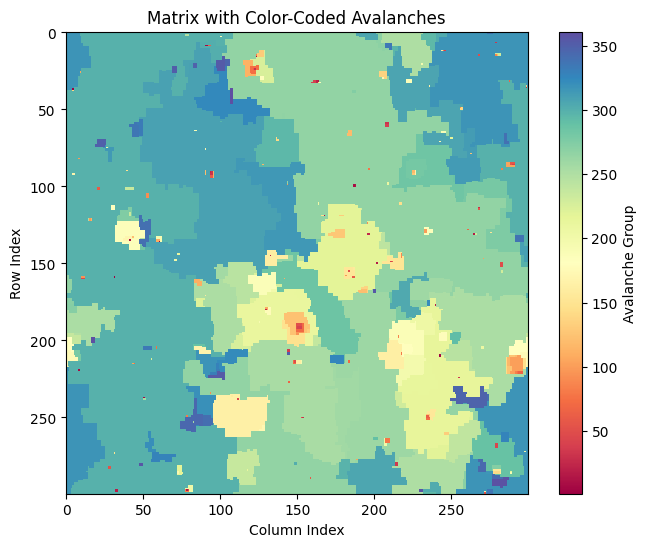

In [17]:
num_groups = len(avalanches)
colors = plt.cm.get_cmap('Spectral', num_groups)
color_dict = {i: colors(i)for i in range(num_groups)}

color_matrix = np.zeros_like (s, dtype=float)

for group_idx, avalanche in enumerate(avalanches):
  for idx in avalanche:
    i, j = idx
    color_matrix[i, j] = group_idx + 1

plt.figure(figsize=(8, 6))
plt.imshow(color_matrix, cmap=ListedColormap(list(color_dict.values())), interpolation='nearest')
plt.colorbar(label='Avalanche Group')
plt.title('Matrix with Color-Coded Avalanches')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

In [18]:
s,h = InitLattice(300,300,0.7)
avalanches = []
H = -1000000000
J = 1
while np.count_nonzero(s == -1) > 0:
  same_avalanche, H = PropagateAvalanche(s,h,J,H)
  avalanches.append(same_avalanche)

<ipython-input-19-d4dd17902617>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Spectral', num_groups)


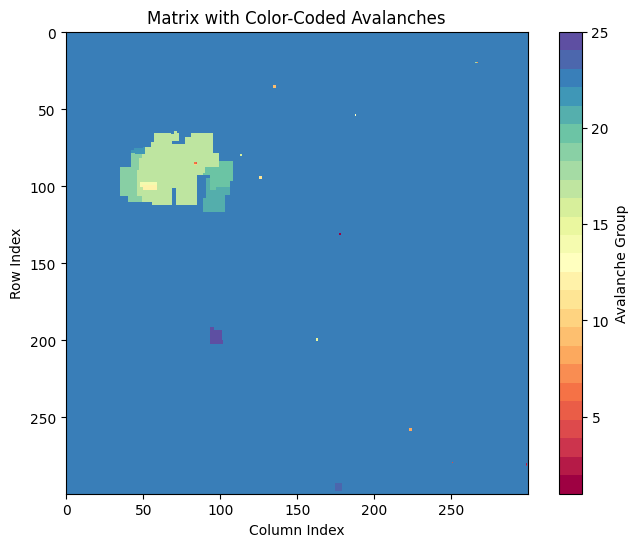

In [19]:
num_groups = len(avalanches)
colors = plt.cm.get_cmap('Spectral', num_groups)
color_dict = {i: colors(i)for i in range(num_groups)}

color_matrix = np.zeros_like (s, dtype=float)

for group_idx, avalanche in enumerate(avalanches):
  for idx in avalanche:
    i, j = idx
    color_matrix[i, j] = group_idx + 1

plt.figure(figsize=(8, 6))
plt.imshow(color_matrix, cmap=ListedColormap(list(color_dict.values())), interpolation='nearest')
plt.colorbar(label='Avalanche Group')
plt.title('Matrix with Color-Coded Avalanches')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

#### Exercise 4.4

There are lots of properties that one might wish to measure about this system: avalanche sizes, avalanche correlation functions, hysteresis loop shapes, average pulse shapes during avalanches. It can get ugly if you put all of these measurements inside the inner loop of your code. Instead, we suggest that you try the subject/observer design pattern: each time a spin is flipped, and each time an
avalanche is finished, the subject (our simulation) notifies the list of observers.

Build a MagnetizationObserver, which stores an internal magnetization starting at $-N$, adding two to it whenever it is notifed. Build an AvalancheSizeObserver, which keeps track of the growing size of the current avalanche after each spin  flip, and adds the final size to a histogram of all previous avalanche sizes when the avalanche ends.

Set up NotifySpinFlip and NotifyAvalancheEnd function for your simulation, and add the two observers appropriately. Plot the magnetization curve $M(H)$ and the avalanche size distribution histogram $D(S)$ for the three systems you ran for exercise 4.3


In [20]:
class MagnetizationObserver:

    def __init__(self, initial_magnetization, initial_H):
        self.magnetization = [initial_magnetization]
        self.H = [initial_H]

    def notify_spin_flip(self,H_new):
        self.magnetization.append(self.magnetization[-1] + 2)
        self.H.append(H_new)

    def get_magnetization(self):
        return self.magnetization

    def get_H(self):
        return self.H


class AvalancheSizeObserver:

    def __init__(self):
        self.current_avalanche_size = 0
        self.avalanche_sizes = []

    def notify_spin_flip(self):
        self.current_avalanche_size += 1

    def notify_avalanche_end(self):
        self.avalanche_sizes.append(self.current_avalanche_size)
        self.current_avalanche_size = 0

    def get_avalanche_sizes(self):
        return self.avalanche_sizes

In [21]:
@jit
def PropagateAvalanchev2(s,h,J,H,  m_observer=None, a_observer=None):
    """function that propagates an avalanche given the triggering spin at i,j
    coloring the spins that are flipped """

    q = Queue()
    same_avalance = []
    i, j, fm = BruteForceNextAvalanche(s,h,J,H)
    H_increment = - fm
    H += H_increment
    q.enqueue([i,j])
    same_avalance.append([i,j])

    while q.isEmpty()==False:
      i, j = q.dequeue()
      _, flag = FlipSpin(i,j,s)

      if flag == 1:
        m_observer.notify_spin_flip(H)
        a_observer.notify_spin_flip()
        y = s.shape[0]
        x = s.shape[1]
        left_i = (i-1)%x
        right_i = (i+1)%x
        up_j = (j+1)%y
        down_j = (j-1)%y
        neigh = [[left_i,j], [right_i,j], [i,up_j], [i,down_j]]

        for i, j in neigh:
          sum_neigh = -4 + 2*NeighborsUp(i,j,s)
          local_field = J* sum_neigh+h[i,j] + H

          if local_field > 0 and s[i,j]==-1:
            q.enqueue([i,j])
            same_avalance.append([i,j])

    a_observer.notify_avalanche_end()
    return same_avalance, H

<ipython-input-21-773a443414bf>:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def PropagateAvalanchev2(s,h,J,H,  m_observer=None, a_observer=None):


In [22]:
s,h = InitLattice(300,300,0.7)
all_avalanches3 = []
H = -1000000000
J = 1
m_observer3 = MagnetizationObserver(-300, H)
a_observer3 = AvalancheSizeObserver()
while np.count_nonzero(s == -1) > 0:
  same_avalanche, H = PropagateAvalanchev2(s,h,J,H, m_observer3, a_observer3)
  all_avalanches3.append(same_avalanche)

<ipython-input-21-773a443414bf>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "PropagateAvalanchev2" failed type inference due to: Untyped global name 'Queue': Cannot determine Numba type of <class 'type'>

File "<ipython-input-21-773a443414bf>", line 6:
def PropagateAvalanchev2(s,h,J,H,  m_observer=None, a_observer=None):
    <source elided>
    
    q = Queue()
    ^

  @jit
/usr/local/lib/python3.10/dist-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "PropagateAvalanchev2" was compiled in object mode without forceobj=True.

File "<ipython-input-21-773a443414bf>", line 2:
@jit
def PropagateAvalanchev2(s,h,J,H,  m_observer=None, a_observer=None):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/usr/local/lib/python3.10/dist-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected. This is dep

In [23]:
s,h = InitLattice(300,300,0.9)
all_avalanches2 = []
H = -1000000000
J = 1
m_observer2 = MagnetizationObserver(-300, H)
a_observer2 = AvalancheSizeObserver()
while np.count_nonzero(s == -1) > 0:
  same_avalanche, H = PropagateAvalanchev2(s,h,J,H, m_observer2, a_observer2)
  all_avalanches2.append(same_avalanche)

In [24]:
s,h = InitLattice(300,300,1.4)
all_avalanches1 = []
H = -1000000000
J = 1
m_observer1 = MagnetizationObserver(-300, H)
a_observer1 = AvalancheSizeObserver()
while np.count_nonzero(s == -1) > 0:
  same_avalanche, H = PropagateAvalanchev2(s,h,J,H, m_observer1, a_observer1)
  all_avalanches1.append(same_avalanche)

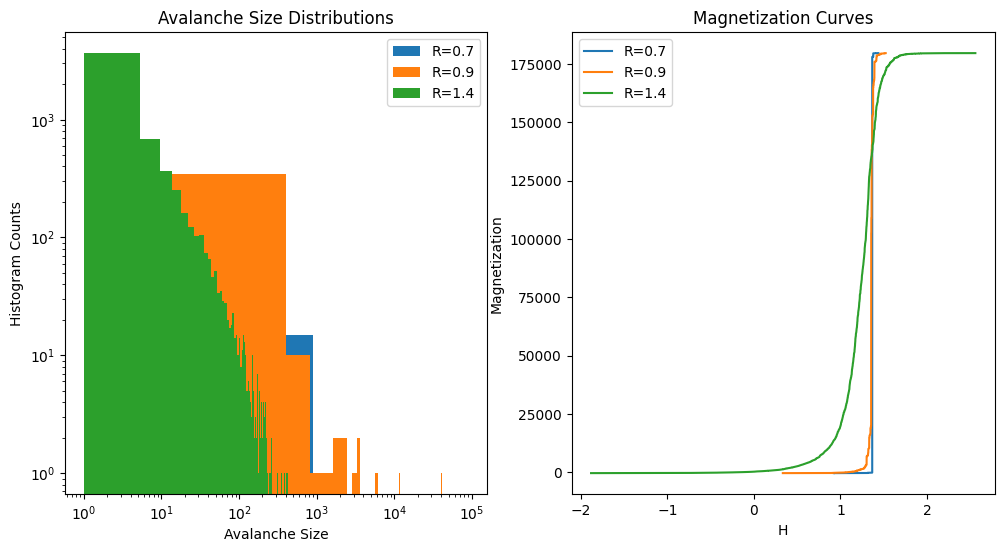

In [25]:
fig_hist, ax = plt.subplots(1,2,figsize=(12, 6))

ax[0].hist(a_observer3.get_avalanche_sizes(), bins=100, label="R=0.7")
ax[0].hist(a_observer2.get_avalanche_sizes(), bins=100, label="R=0.9")
ax[0].hist(a_observer1.get_avalanche_sizes(), bins=100, label="R=1.4")

ax[0].set_xlabel("Avalanche Size")
ax[0].set_ylabel("Histogram Counts")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title("Avalanche Size Distributions")


ax[1].plot(m_observer3.get_H()[2:], m_observer3.get_magnetization()[2:], label="R=0.7")
ax[1].plot(m_observer2.get_H()[2:], m_observer2.get_magnetization()[2:], label="R=0.9")
ax[1].plot(m_observer1.get_H()[2:], m_observer1.get_magnetization()[2:], label="R=1.4")


ax[1].set_xlabel("H")
ax[1].set_ylabel("Magnetization")
ax[1].legend()
ax[1].set_title("Magnetization Curves")

plt.show()

## The sorted list algorithm
The brute-force algorithm for finding the next avalanche for a system with $N$ spins takes a time of order $N$ per avalanche. Since there are roughly N avalanches the time for the brute-force algorithm scales as $N^2$. We can use a sorted list to speed op our algorithm.

We make a list of the spins in order of their random elds. Given a field range $(H,H+\Delta)$ in a lattice with z neighbors per site (4 in $d=2$), only those spins with random  fields in the range $JS + H < h_i < JS +(H +\Delta)$ need to be checked, for the $z+1$ possible fields $JS = (-Jz,-J(z+1), ..., Jz)$, from the
neighbors. We can keep track of the locations in thesorted list of the $z + 1$ possible next spins to flip. The spins can be sorted in time $N \log N$, which is
practically indistinguishable from linear in $N$, and a big improvement over the brute-force algorithm.

![image.png](attachment:1455b713-c75d-4169-bf19-1b178b72fcb4.png)

#### Exercise 4.5
Write a sorted list algorithm according to the following steps:

1. Define an array nextPossible[nUp], which points to the location in the sorted list of the next spin that would  flip if it had nUp neighbors. Initially, all the elements of nextPossible[nUp] point to the spin with the largest random  field $h_i$.
2. From the z + 1 spins pointed to by nextPossible, choose the one nUpNext with
the largest internal  fleld in nUp - nDown + $h_i$ = 2 nUp - z +$h_i$. Do not check values of nUp for which the pointer has fallen off  the end of the list; use a variable stopNUP.
3. Move the pointer nextPossible[nUpNext] to the next spin on the sorted list. If you have fallen o  the end of the list, decrement stopNUP.
4. If the spin nUpNext has exactly the right number of up-neighbors, flip it, increment the external field H(t), and start the next avalanche. Otherwise go back to step (2).

Implement the sorted list algorithm for  finding the next avalanche. Notice the pause at the beginning of the simulation; most of the computer time ought to be spent sorting the list. Compare the timing with your brute-force algorithm for a moderate system size, where the brute-force algorithm is slightly painful to run.

In [52]:
def get_sorted_list(h):
    spin_field_list = [[i, j, h[i,j]] for i in range(h.shape[0]) for j in range(h.shape[1])]
    sorted_spin_field_list = sorted(spin_field_list, key=lambda x: -x[2])
    return sorted_spin_field_list

In [35]:
s,h = InitLattice(10,10,0.9)
sorted_spin_list = get_sorted_list(h)

In [47]:
max(h.flatten())

1.656861563296253

In [48]:
sorted_spin_list[0]

array([2.        , 6.        , 1.65686156])

In [53]:
def NextAvalanche(s,h,J,H, sorted_spin_list, control=False):
  nextPossible = np.zeros((5))
  stopNUp = 5
  max_hi = -np.infty
  nUpNext = 0
  already_checked = []
  while True:
    for n_uP in range(0,stopNUp):
      pointer = int(nextPossible[n_uP])
      if pointer < len(sorted_spin_list) and sorted_spin_list[pointer] not in already_checked:
        hi = sorted_spin_list[pointer][2]
        h_int = 2 * n_uP - 4 + hi
        if h_int > max_hi:
          max_hi = h_int
          nUpNext = n_uP
          already_checked.append(sorted_spin_list[pointer])

    if stopNUp == 0:
      pointer = int(nextPossible[0])
      if pointer < len(sorted_spin_list) and sorted_spin_list[pointer] not in already_checked:
            hi = sorted_spin_list[pointer][2]
            h_int = 2 * 0 - 4 + hi
            nUpNext = 0
            max_hi=h_int
            already_checked.append(sorted_spin_list[pointer])

    if stopNUp>=0:
      nextPossible[nUpNext] = int(nextPossible[nUpNext]) + 1
      if int(nextPossible[nUpNext]) > len(sorted_spin_list)-1:
        stopNUp -= 1
      else:
        i, j, hi = sorted_spin_list[int(nextPossible[nUpNext])]

        if control == True and s[i,j] == -1:
          print(i,j,hi,NeighborsUp(i,j,s), nUpNext, s[i,j])
        if NeighborsUp(i,j,s) == nUpNext and s[i,j] == -1:
          sum_neigh = -4 + 2 * nUpNext
          fm = J * sum_neigh+hi + H
          sorted_spin_list.pop(int(nextPossible[nUpNext]))
          return i,j,fm
          break
    else:
      # using BruteForce algorithm for the last few avalanches, error raises otherwise
      return BruteForceNextAvalanche(s,h,J,H)
      break

In [54]:
def PropagateAvalanchev3(s, h, J, H, sorted_spin_list):
    """function that propagates an avalanche given the triggering spin at i,j
    coloring the spins that are flipped """

    q = Queue()
    same_avalance = []
    i, j, fm = NextAvalanche(s,h,J,H, sorted_spin_list)
    H_increment = - fm
    H += H_increment
    q.enqueue([i,j])
    same_avalance.append([i,j])

    while q.isEmpty() == False:
      i, j = q.dequeue()
      _, flag = FlipSpin(i,j,s)
      if flag == 1:
        y = s.shape[0]
        x = s.shape[1]
        left_i = (i-1) % x
        right_i = (i+1) % x
        up_j = (j+1) % y
        down_j = (j-1) % y
        neigh = [[left_i,j], [right_i,j], [i,up_j], [i,down_j]]

        for i, j in neigh:
          sum_neigh = -4 + 2* NeighborsUp(i,j,s)
          local_field = J * sum_neigh+h[i,j] + H
          if local_field > 0 and s[i,j] == -1:
            q.enqueue([i,j])
            same_avalance.append([i,j])
    return same_avalance, H

In [55]:
%%time
s,h = InitLattice(300, 300, 1.4)
sorted_spin_list = get_sorted_list(h)
H = -1000000000
J = 1
avalanche_spins = []
while np.count_nonzero(s == -1) > 0:
    same_avalanche, H = PropagateAvalanchev3(s, h, J, H, sorted_spin_list)
    avalanche_spins.append(same_avalanche)

CPU times: user 56.5 s, sys: 117 ms, total: 56.6 s
Wall time: 58.1 s


In [56]:
def color_plot(avalanche_spins):
    num_groups = len(avalanche_spins)
    colors = plt.cm.get_cmap('Spectral', num_groups)
    color_dict = {i: colors(i) for i in range(num_groups)}

    color_matrix = np.zeros_like(s, dtype=float)

    for group_idx, avalanche in enumerate(avalanche_spins):
        for idx in avalanche:
            i, j = idx
            color_matrix[i, j] = group_idx + 1

    plt.figure(figsize=(8, 6))
    plt.imshow(color_matrix, cmap=ListedColormap(list(color_dict.values())), interpolation='nearest')
    plt.colorbar(label='Avalanche Group')
    plt.title('Matrix with Color-Coded Avalanches')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

<ipython-input-56-a1bd03cdf028>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Spectral', num_groups)


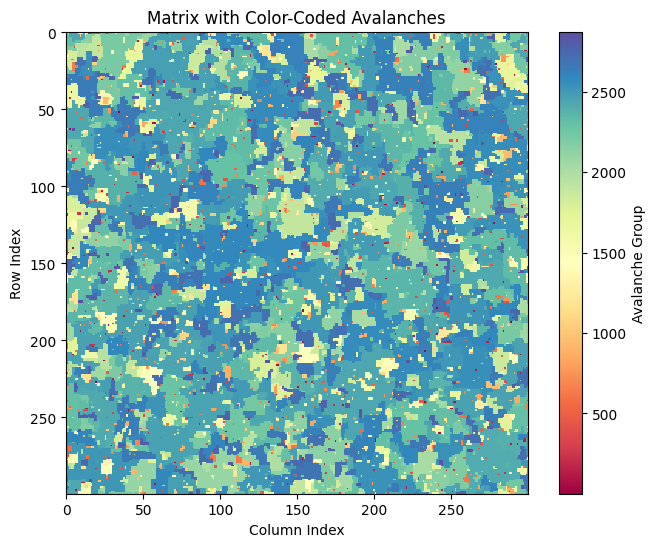

In [57]:
color_plot(avalanche_spins)

The optimized version of the algorithm is extremely faster than the brute force one.

The time to run the new version of the algorithm for a system with size (300,300) and variance R = 1.4 is 20 seconds, while with the old version is 20 minutes and 38 seconds (for the same system's parameters).